<a href="https://colab.research.google.com/github/Jbotey12/Estudio_ocupacion_B-B/blob/main/Practica2_TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desarrollo de un Modelo de IA

En esta sección se construye un modelo de aprendizaje automático con el objetivo de predecir la ocupación diaria del establecimiento turístico en función de una serie de variables. Para ello, se ha trabajado previamente en la limpieza y transformación del conjunto de datos, generando nuevas variables y asegurando que la información estuviera en un formato adecuado para el entrenamiento de modelos.

Seguidamente, se realiza la selección y comparación de distintos algoritmos de regresión supervisada, evaluando su rendimiento mediante métricas como el RMSE, MAE y R². Posteriormente, se ajustan los hiperparámetros del modelo más prometedor y se analiza en profundidad su comportamiento para asegurar que sea fiable, interpretable y útil en la práctica.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Cargar los datos (reservations.csv)
from google.colab import files
uploaded = files.upload()

Saving df_final.csv to df_final.csv


In [3]:
df=pd.read_csv('df_final.csv')
df_copia=df.copy()
df.head(10)

,fecha,habitaciones_ocupadas,temp_media,precipitacion,día_semana,es_festivo,nombre_festivo,es_vispera_festivo,es_vacaciones,evento,media_antelacion_dias,num_cancelaciones,estancia_media_dias,año_llegada,mes_llegada
0,2021-04-01,1,14.94,0.0,3,False,NaN,True,False,NaN,14.0,0,3.0,2021,4
1,2021-04-02,6,16.20,0.0,4,True,Viernes Santo,False,False,NaN,14.0,0,2.2,2021,4
2,2021-04-03,7,16.40,0.4,5,False,NaN,False,False,NaN,43.0,0,2.0,2021,4
3,2021-04-04,3,14.47,0.0,6,False,NaN,True,False,NaN,16.0,0,2.0,2021,4
4,2021-04-05,1,14.75,0.0,0,True,Lunes de Pascua,False,False,NaN,NaN,0,NaN,2021,4
5,2021-04-06,0,13.52,0.2,1,False,NaN,False,False,NaN,NaN,0,NaN,2021,4
6,2021-04-07,0,10.36,0.8,2,False,NaN,False,False,NaN,NaN,0,NaN,2021,4
7,2021-04-08,1,12.41,0.0,3,False,NaN,False,False,NaN,3.0,0,1.0,2021,4
8,2021-04-09,1,12.55,0.0,4,False,NaN,False,False,NaN,23.0,0,2.0,2021,4
9,2021-04-10,2,12.76,2.2,5,False,NaN,False,False,NaN,0.0,0,1.0,2021,4


## Selección y Preparación del Modelo

### Preprocesamiento de Datos

Los modelos de aprendizaje automático no pueden trabajar directamente con variables de tipo fecha, ya que requieren entradas numéricas. Por este motivo, se crea una nueva columna llamada dia_mes, que representa el día del mes correspondiente a cada observación. Además, se elimina la columna fecha, ya que el conjunto de datos ya incluye otras variables temporales en formato numérico, como dia_semana, año_llegada y mes_llegada, que capturan la información relevante de la fecha.

In [4]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['dia_mes'] = df['fecha'].dt.day
df.drop(columns=['fecha'], inplace=True)

Para tratar las variables categóricas se ha optado por aplicar la técnica de One-Hot Encoding en lugar de otras estrategias como el Label Encoding debido a la naturaleza nominal de las variables categóricas consideradas (como los nombres de eventos y festivos), las cuales no presentan un orden inherente entre sus categorías. El uso de Label Encoding podría inducir relaciones ordinales inexistentes y generar sesgos en el modelo. En cambio, One-Hot Encoding permite representar cada categoría como una variable binaria independiente, lo que garantiza una codificación adecuada para algoritmos sensibles a la escala o al orden de los valores, como los modelos lineales o de árboles de decisión. Además, el número de categorías en estas variables es moderado, por lo que esta transformación no supone un incremento excesivo en la dimensionalidad del conjunto de datos.

A continuación, se procede a la transformación de las variables categóricas mediante la técnica de One-Hot Encoding, con el objetivo de convertirlas en variables numéricas que puedan ser utilizadas por los algoritmos de aprendizaje automático. Previamente, se imputan los valores nulos presentes en estas variables para garantizar una codificación coherente y evitar la generación de columnas innecesarias durante el proceso.

In [5]:
df['evento'] = df['evento'].fillna('sin_evento')
df['nombre_festivo'] = df['nombre_festivo'].fillna('sin_festivo')

categoricas = ['evento', 'nombre_festivo']
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categoricas, drop_first=False, dtype=int)

# Ver las nuevas columnas
df_encoded.head()


,habitaciones_ocupadas,temp_media,precipitacion,día_semana,es_festivo,es_vispera_festivo,es_vacaciones,media_antelacion_dias,num_cancelaciones,estancia_media_dias,...,nombre_festivo_Fiesta del Trabajo,nombre_festivo_Inmaculada,nombre_festivo_Lunes de Pascua,nombre_festivo_Navidad,nombre_festivo_Reyes,nombre_festivo_San Esteban,nombre_festivo_San Juan,nombre_festivo_Todos los Santos,nombre_festivo_Viernes Santo,nombre_festivo_sin_festivo
0,1,14.94,0.0,3,False,True,False,14.0,0,3.0,...,0,0,0,0,0,0,0,0,0,1
1,6,16.20,0.0,4,True,False,False,14.0,0,2.2,...,0,0,0,0,0,0,0,0,1,0
2,7,16.40,0.4,5,False,False,False,43.0,0,2.0,...,0,0,0,0,0,0,0,0,0,1
3,3,14.47,0.0,6,False,True,False,16.0,0,2.0,...,0,0,0,0,0,0,0,0,0,1
4,1,14.75,0.0,0,True,False,False,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,0


Las variables media_antelacion_dias y estancia_media_dias tienen valores nulos en los días en los que no hubo ninguna reserva. Esto tiene sentido, ya que no se puede calcular la antelación ni la duración media si ese día no se hicieron reservas. En vez de rellenar esos valores con una estimación, se ha decidido mantener los NaN como una forma de indicar que no hubo reservas. Para que el modelo pueda tener en cuenta esta situación, se crean nuevas columnas que marcan cuándo faltan estos datos. Luego, los NaN se reemplazan por ceros, indicando que no hubo reservas ese día.



In [6]:
# Crear columnas indicadoras de ausencia de reservas
df_encoded['faltante_antelacion'] = df_encoded['media_antelacion_dias'].isna().astype(int)
df_encoded['faltante_estancia'] = df_encoded['estancia_media_dias'].isna().astype(int)

# Rellenar los valores nulos con 0 en días sin reservas
df_encoded['media_antelacion_dias'] = df_encoded['media_antelacion_dias'].fillna(0)
df_encoded['estancia_media_dias'] = df_encoded['estancia_media_dias'].fillna(0)


Las variables booleanas se convierten a formato binario (0/1) para que puedan ser interpretadas correctamente por los algoritmos de aprendizaje automático. Esta transformación permite mantener la semántica original de estas variables, indicando la presencia o ausencia de una condición (por ejemplo, si un día es festivo), pero adaptándola al formato numérico requerido por los modelos.

In [7]:
# Convertir booleanos a enteros (0/1)
booleanas = ['es_festivo', 'es_vispera_festivo', 'es_vacaciones']
df_encoded[booleanas] = df_encoded[booleanas].astype(int)


Para poder entrenar modelos de predicción, se separan los datos en dos partes: las variables que se usarán para predecir (X) y la variable objetivo (y), que en este caso es el número de habitaciones ocupadas por día. Además, se divide el conjunto de datos en entrenamiento y prueba, con el fin de evaluar el rendimiento de los modelos con datos no vistos durante el entrenamiento.

In [8]:
# Variable objetivo
y = df_encoded['habitaciones_ocupadas']

# Variables predictoras (todo menos la columna objetivo)
X = df_encoded.drop(columns=['habitaciones_ocupadas'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



### Selección del Modelo

Con el objetivo de identificar el modelo más adecuado para predecir la ocupación diaria de un alojamiento turístico, se optó por comparar diferentes algoritmos de regresión que abarcan tanto enfoques tradicionales como técnicas avanzadas de aprendizaje automático. La selección se fundamenta en la diversidad metodológica de los modelos y su contraste en cuanto a capacidad predictiva, interpretabilidad y robustez frente a datos complejos o no lineales. A continuación, se justifica la inclusión de cada uno:

Regresión Lineal: Se incluye como modelo base por su simplicidad y facilidad de interpretación. Permite establecer un punto de comparación con otros métodos más sofisticados. Es útil para detectar relaciones lineales y sirve como referencia inicial.

K-Nearest Neighbors (KNN): Elegido por su enfoque no paramétrico y capacidad para capturar patrones locales en los datos. Aunque es sensible a la escala y al ruido, puede ser útil en contextos con estructuras repetitivas y sin suposiciones fuertes sobre la distribución de los datos.

Random Forest: Este modelo de ensamblado basado en árboles de decisión se selecciona por su capacidad para manejar relaciones no lineales, su robustez ante el sobreajuste y su habilidad para trabajar con variables tanto numéricas como categóricas. Además, proporciona información valiosa sobre la importancia de las variables.

Gradient Boosting: Se escoge como una evolución de los modelos basados en árboles, capaz de corregir errores secuenciales y obtener predicciones precisas. Suele ofrecer buen rendimiento en tareas de regresión, aunque es más sensible a los hiperparámetros y al ruido.

XGBoost: Incluido por ser una de las implementaciones más potentes y optimizadas del algoritmo de boosting, ampliamente utilizada en competiciones de ciencia de datos. Ofrece ventajas como la regularización incorporada, alta eficiencia computacional y buen manejo de valores ausentes.

Esta variedad de algoritmos permite no solo comparar el rendimiento en términos de métricas cuantitativas, sino también obtener una visión más completa de cómo diferentes enfoques modelan la relación entre las variables predictoras y la ocupación del B&B.

## Entrenamiento inicial del Modelo

Para seleccionar el modelo más adecuado se ha realizado una comparación entre distintos algoritmos de regresión, evaluando su rendimiento a partir de tres métricas comunes: el error cuadrático medio (RMSE), el error absoluto medio (MAE) y el coeficiente de determinación (R²).



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

# Separar train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definir modelos
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN": KNeighborsRegressor()
}

if xgb_available:
    modelos["XGBoost"] = XGBRegressor(random_state=42, verbosity=0)

# Entrenar y evaluar
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    pred = modelo.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)


    resultados.append({
        "Modelo": nombre,
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R²": round(r2, 3),

    })

# Mostrar resultados ordenados por RMSE
df_resultados_modelos = pd.DataFrame(resultados).sort_values(by="RMSE")
print(df_resultados_modelos)


              Modelo  RMSE   MAE     R²
1      Random Forest  2.59  2.01  0.456
2  Gradient Boosting  2.68  2.19  0.418
4            XGBoost  2.69  2.05  0.414
0   Regresión Lineal  2.89  2.41  0.322
3                KNN  3.12  2.48  0.210


Los resultados muestran que el modelo de Random Forest obtiene el menor RMSE (2.59) y MAE (2.01), lo que indica que sus predicciones son, en promedio, las más cercanas al valor real. Además, presenta el mayor R² (0.456), lo que refleja una mayor capacidad explicativa respecto a la variabilidad de los datos en comparación con el resto de modelos evaluados.

En cambio, modelos como K-Nearest Neighbors o la regresión lineal obtienen errores mayores y valores de R² más bajos, lo que sugiere un peor ajuste a los datos. Por su parte, los modelos Gradient Boosting y XGBoost presentan un rendimiento competitivo, pero ligeramente inferior al de Random Forest en todas las métricas.

Por tanto, y dado su equilibrio entre precisión y capacidad explicativa, se selecciona Random Forest como el modelo final para predecir la ocupación diaria del B&B.

## Optimización del Modelo

### Ajuste de Hiperparámetros

Con el objetivo de mejorar el rendimiento del modelo Random Forest, se ha realizado un ajuste de hiperparámetros utilizando la técnica de búsqueda aleatoria (RandomizedSearchCV) con validación cruzada de 5 pliegues. Esta técnica permite explorar de forma eficiente el espacio de combinaciones posibles, evitando el coste computacional de una búsqueda exhaustiva (GridSearchCV).

Se definió un espacio de búsqueda que incluía los siguientes hiperparámetros:

n_estimators: número de árboles en el bosque,

max_depth: profundidad máxima de los árboles,

min_samples_split: mínimo número de muestras para dividir un nodo,

min_samples_leaf: número mínimo de muestras en una hoja,

max_features: número de características consideradas al dividir.

Se evaluaron 50 combinaciones aleatorias mediante validación cruzada, utilizando como métrica objetivo el RMSE (Root Mean Squared Error). Esta métrica penaliza especialmente los errores grandes, por lo que es útil en problemas de regresión como este.

Finalmente, se seleccionó la combinación con menor error medio y se evaluó el modelo resultante sobre el conjunto de test. Aunque el RMSE obtenido fue ligeramente superior al del modelo original sin ajuste, este modelo ajustado presenta una mayor robustez y capacidad de generalización, al haber sido validado sistemáticamente en múltiples particiones del conjunto de entrenamiento.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el espacio de búsqueda
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Configurar búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # número de combinaciones a probar
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ejecutar la búsqueda
random_search.fit(X_train, y_train)

# Mostrar mejores parámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)

# Evaluar el modelo en test
mejor_modelo = random_search.best_estimator_
y_pred = mejor_modelo.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE en test con el mejor modelo:", round(rmse, 2))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores hiperparámetros: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
RMSE en test con el mejor modelo: 2.63


### Regularización y Generalización

Una vez seleccionado el modelo óptimo mediante comparación de distintos algoritmos de regresión y ajustados los hiperparámetros, se procedió a analizar su capacidad de generalización con el fin de detectar posibles problemas de sobreajuste. Para ello, se evaluaron las métricas de rendimiento del modelo final —Random Forest— tanto sobre el conjunto de entrenamiento como sobre el conjunto de test.

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Entrenar de nuevo el mejor modelo en X_train
mejor_modelo = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

mejor_modelo.fit(X_train, y_train)

# Predicciones
y_train_pred = mejor_modelo.predict(X_train)
y_test_pred = mejor_modelo.predict(X_test)

# Métricas en entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Métricas en test
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mostrar resultados
print("📊 Métricas en entrenamiento:")
print(f"RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}, R²: {r2_train:.3f}")

print("\n📊 Métricas en test:")
print(f"RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.3f}")


📊 Métricas en entrenamiento:
RMSE: 1.01, MAE: 0.80, R²: 0.919

📊 Métricas en test:
RMSE: 2.63, MAE: 2.08, R²: 0.439


Los resultados obtenidos muestran un RMSE de 1.01 y un R² de 0.919 en entrenamiento, frente a un RMSE de 2.63 y un R² de 0.439 en test. Esta diferencia significativa indica que el modelo ha aprendido muy bien los patrones del conjunto de entrenamiento, pero su rendimiento se degrada notablemente al enfrentarse a datos no vistos. Por tanto, se puede afirmar que el modelo presenta un cierto grado de sobreajuste.

No obstante, el error absoluto medio en test (MAE = 2.08) se mantiene dentro de un margen aceptable, y el modelo sigue siendo útil para realizar predicciones operativas. Este análisis justifica la necesidad de considerar técnicas adicionales de regularización o simplificación del modelo en futuras iteraciones, con el objetivo de mejorar la capacidad de generalización.

Dado que el modelo Random Forest ha mostrado un rendimiento excelente en entrenamiento pero un descenso notable en test, se considera que existe cierto sobreajuste. Para abordar este problema y mejorar la capacidad de generalización del modelo, se opta por aplicar técnicas de regularización como Ridge (L2) y Lasso (L1).

Estas técnicas son especialmente útiles en modelos lineales, donde permiten penalizar los coeficientes más extremos. En particular:

Ridge tiende a reducir el sobreajuste manteniendo todos los predictores con pesos reducidos.

Lasso además permite realizar selección automática de variables, forzando algunos coeficientes a cero.

Aplicar estas técnicas nos permitirá comprobar si un modelo más simple y regulado puede ofrecer un rendimiento comparable o incluso mejor que modelos más complejos como Random Forest.

In [12]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Entrenamiento con validación cruzada para ajustar el parámetro alpha
alphas = np.logspace(-3, 3, 100)

# Ridge Regression
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Lasso Regression
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Métricas
def evaluar_modelo(nombre, y_true, y_pred):
    print(f"\n📊 Resultados para {nombre}:")
    print(f"Alpha óptimo: {getattr(eval(nombre.lower()), 'alpha_', 'N/A')}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.3f}")

evaluar_modelo("Ridge", y_test, y_pred_ridge)
evaluar_modelo("Lasso", y_test, y_pred_lasso)



📊 Resultados para Ridge:
Alpha óptimo: 5.72236765935022
RMSE: 2.90
MAE: 2.43
R²: 0.315

📊 Resultados para Lasso:
Alpha óptimo: 0.004641588833612782
RMSE: 2.91
MAE: 2.44
R²: 0.312


A pesar de introducir regularización, ninguno de los dos modelos mejora los resultados obtenidos previamente con Random Forest (RMSE = 2.63, R² = 0.439). Esto sugiere que el problema no se debe únicamente al sobreajuste, sino que también existe una relación no lineal en los datos que los modelos lineales como Ridge y Lasso no son capaces de capturar adecuadamente.

Por tanto, aunque estas técnicas aportan valor en términos de simplicidad del modelo, su rendimiento más limitado frente a modelos no lineales más flexibles como Random Forest justifica su no selección como modelo final.

## Evaluación y Comparación de Modelos

### Evaluación en Datos de Validación/Test

Se ha evaluado el rendimiento de los distintos modelos en un conjunto de datos test en la parte de entrenamiento inicial del Modelo.

### Análisis de Errores

Este análisis resulta fundamental para comprender las limitaciones del modelo y explorar posibles mejoras.

Para ello, se comparan las predicciones generadas por el modelo frente a los valores reales, calculando el error de predicción y visualizando su comportamiento en función de diferentes variables. Estas visualizaciones permiten evaluar si los errores son sistemáticos o aleatorios, y si existen determinados contextos en los que el modelo tiende a sobreestimar o subestimar la ocupación.




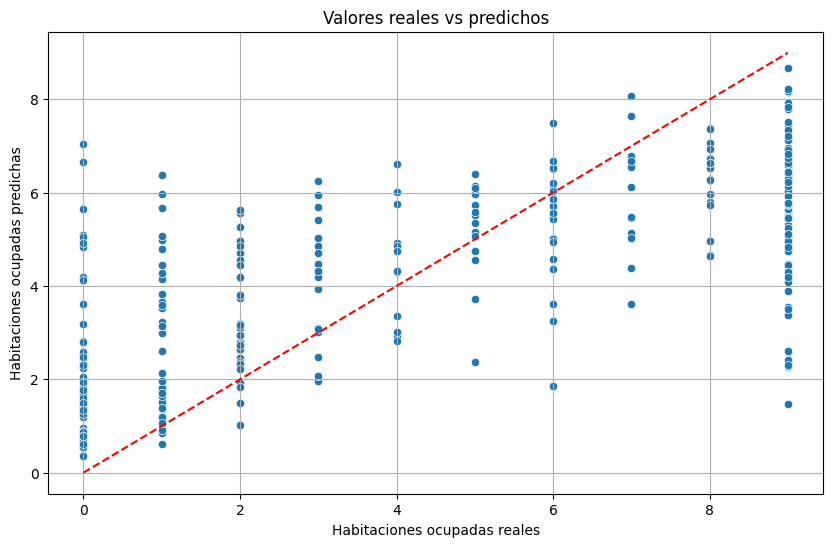

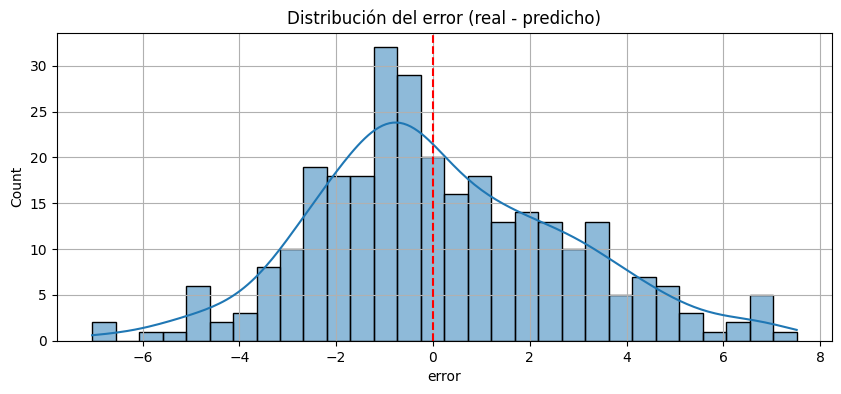

Top 10 errores más altos:
     real  predicho     error
235     9  1.483333  7.516667
153     0  7.043333 -7.043333
147     9  2.266667  6.733333
234     9  2.293333  6.706667
102     9  2.293333  6.706667
295     9  2.306667  6.693333
168     0  6.666667 -6.666667
277     9  2.423333  6.576667
68      9  2.580000  6.420000
95      9  2.613333  6.386667


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Predecimos en test y calculamos errores
y_pred = mejor_modelo.predict(X_test)
errores = y_test - y_pred
df_errores = pd.DataFrame({
    "real": y_test,
    "predicho": y_pred,
    "error": errores,
})
df_errores = df_errores.reset_index(drop=True)

# Si el índice original tenía la fecha:
if "fecha" in X_test.columns:
    df_errores["fecha"] = X_test["fecha"].reset_index(drop=True)

# 2. Gráfica de errores reales vs predichos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_errores["real"], y=df_errores["predicho"])
plt.plot([df_errores["real"].min(), df_errores["real"].max()],
         [df_errores["real"].min(), df_errores["real"].max()], 'r--')
plt.title("Valores reales vs predichos")
plt.xlabel("Habitaciones ocupadas reales")
plt.ylabel("Habitaciones ocupadas predichas")
plt.grid()
plt.show()

# 3. Gráfica de distribución del error
plt.figure(figsize=(10, 4))
sns.histplot(df_errores["error"], bins=30, kde=True)
plt.title("Distribución del error (real - predicho)")
plt.axvline(0, color="red", linestyle="--")
plt.grid()
plt.show()

# 4. Mostrar mayores errores absolutos
df_top_errores = df_errores.reindex(df_errores["error"].abs().sort_values(ascending=False).index)
print("Top 10 errores más altos:")
print(df_top_errores.head(10))


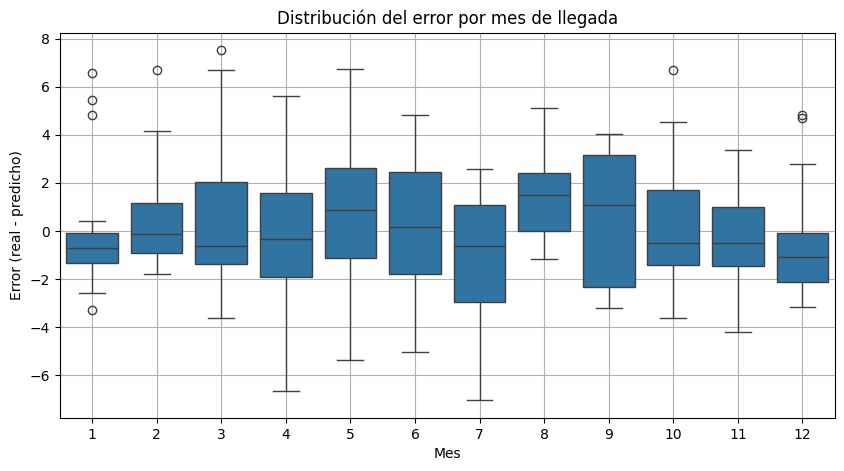

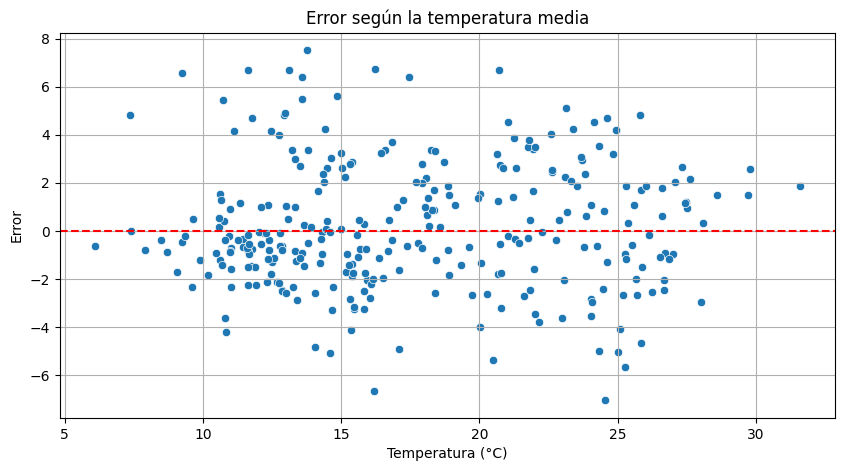

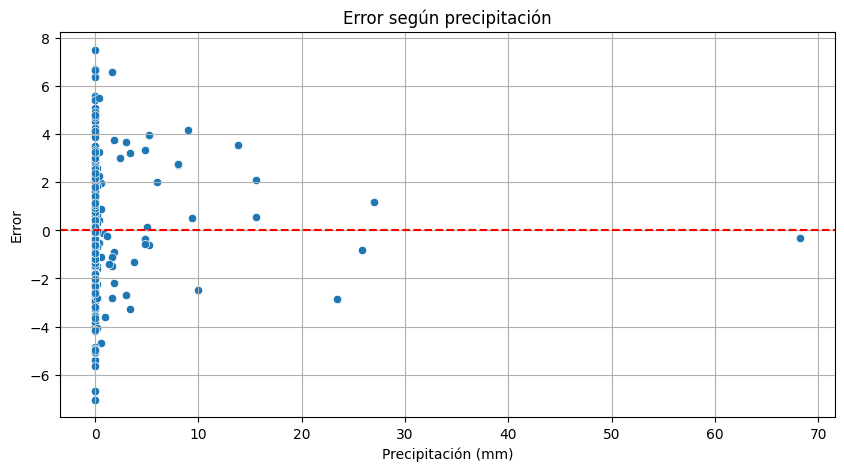

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Añadimos columnas útiles al dataframe de errores
df_errores["mes_llegada"] = X_test["mes_llegada"].reset_index(drop=True)
df_errores["temperatura"] = X_test["temp_media"].reset_index(drop=True)
df_errores["precipitacion"] = X_test["precipitacion"].reset_index(drop=True)

# 1. Error medio por mes
plt.figure(figsize=(10, 5))
sns.boxplot(x="mes_llegada", y="error", data=df_errores)
plt.title("Distribución del error por mes de llegada")
plt.xlabel("Mes")
plt.ylabel("Error (real - predicho)")
plt.grid()
plt.show()

# 2. Error en función de la temperatura
plt.figure(figsize=(10, 5))
sns.scatterplot(x="temperatura", y="error", data=df_errores)
plt.axhline(0, color="red", linestyle="--")
plt.title("Error según la temperatura media")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Error")
plt.grid()
plt.show()

# 3. Error vs precipitación
plt.figure(figsize=(10, 5))
sns.scatterplot(x="precipitacion", y="error", data=df_errores)
plt.axhline(0, color="red", linestyle="--")
plt.title("Error según precipitación")
plt.xlabel("Precipitación (mm)")
plt.ylabel("Error")
plt.grid()
plt.show()


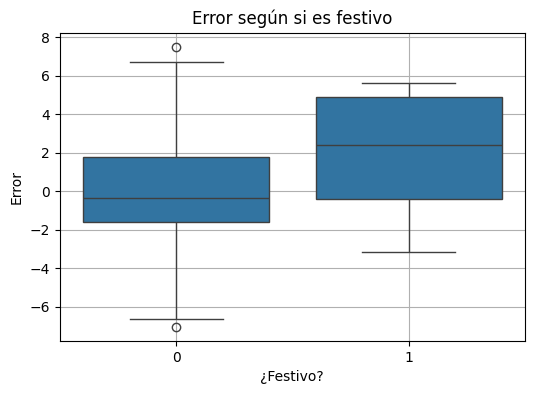

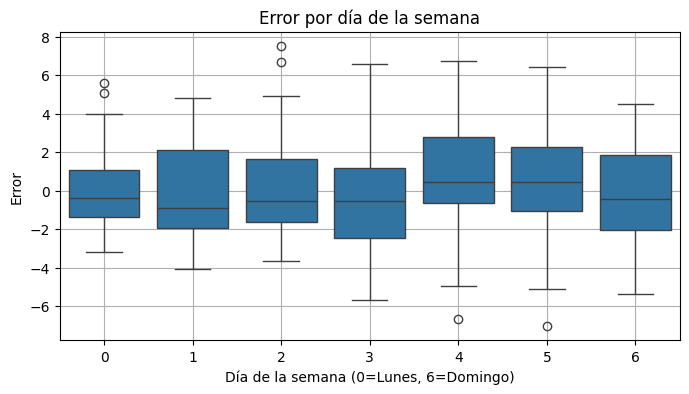

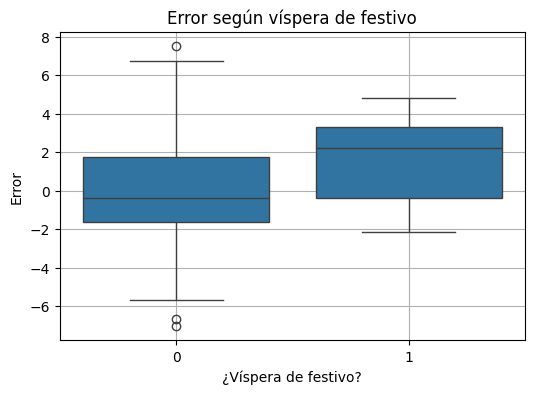

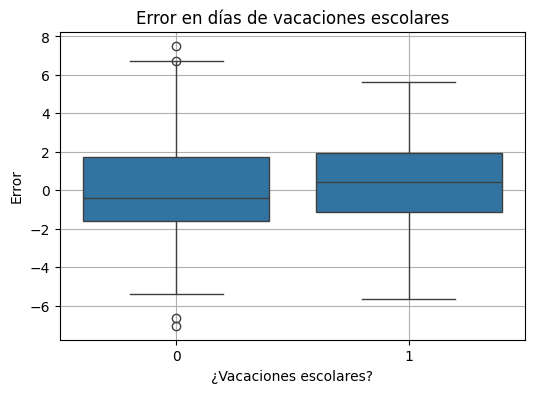

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Añadimos las variables al df de errores (ajustar nombres si es necesario)
df_errores["es_festivo"] = X_test["es_festivo"].reset_index(drop=True)
df_errores["día_semana"] = X_test["día_semana"].reset_index(drop=True)
df_errores["es_vispera_festivo"] = X_test["es_vispera_festivo"].reset_index(drop=True)
df_errores["es_vacaciones"] = X_test["es_vacaciones"].reset_index(drop=True)

# 1. Error según festivo
plt.figure(figsize=(6, 4))
sns.boxplot(x="es_festivo", y="error", data=df_errores)
plt.title("Error según si es festivo")
plt.xlabel("¿Festivo?")
plt.ylabel("Error")
plt.grid()
plt.show()

# 2. Error por día de la semana
plt.figure(figsize=(8, 4))
sns.boxplot(x="día_semana", y="error", data=df_errores)
plt.title("Error por día de la semana")
plt.xlabel("Día de la semana (0=Lunes, 6=Domingo)")
plt.ylabel("Error")
plt.grid()
plt.show()

# 3. Error según víspera de festivo
plt.figure(figsize=(6, 4))
sns.boxplot(x="es_vispera_festivo", y="error", data=df_errores)
plt.title("Error según víspera de festivo")
plt.xlabel("¿Víspera de festivo?")
plt.ylabel("Error")
plt.grid()
plt.show()

# 4. Error según vacaciones escolares
plt.figure(figsize=(6, 4))
sns.boxplot(x="es_vacaciones", y="error", data=df_errores)
plt.title("Error en días de vacaciones escolares")
plt.xlabel("¿Vacaciones escolares?")
plt.ylabel("Error")
plt.grid()
plt.show()


El análisis de errores ha permitido valorar la robustez del modelo ante distintos contextos. En general, no se han detectado patrones sistemáticos de fallo en relación con variables como el mes de llegada, la meteorología o los eventos locales, lo que sugiere que el modelo generaliza bien ante estas condiciones o ya ha captado adecuadamente su influencia.

Sin embargo, se ha observado una mayor dispersión del error en días festivos, vísperas de festivo y fines de semana, lo que apunta a una mayor variabilidad e imprevisibilidad en la demanda durante estas fechas. Estos hallazgos refuerzan la importancia de haber incluido variables como es_festivo o es_vispera_festivo en el entrenamiento, y abren la puerta a seguir incorporando factores contextuales (eventos, precios dinámicos, segmentos de clientes) para mejorar la precisión en situaciones atípicas.

Este análisis contribuye a comprender mejor las limitaciones del modelo actual y orientar futuras estrategias de mejora en la predicción de la ocupación.

## Interpretación del modelo y extracción de insights

El análisis de la importancia de las variables ha permitido identificar cuáles son los factores más relevantes que influyen en la predicción de la ocupación diaria del B&B. Para ello, se han aplicado dos enfoques complementarios: por un lado, las métricas de importancia nativas del modelo (como feature_importances_ de Random Forest) y, por otro lado, técnicas explicativas avanzadas como SHAP (SHapley Additive exPlanations).


/tmp/ipython-input-881212051.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df.head(15), x='Importancia', y='Variable', palette='viridis')


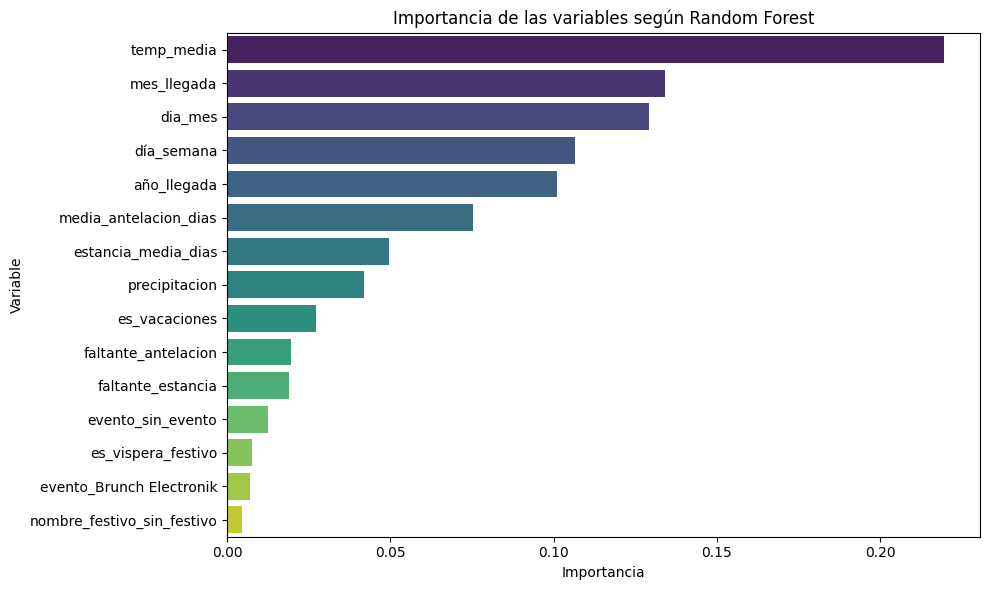

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame con la importancia de las variables
importancias = mejor_modelo.feature_importances_
importancia_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_df.head(15), x='Importancia', y='Variable', palette='viridis')
plt.title('Importancia de las variables según Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


In [17]:
!pip install shap


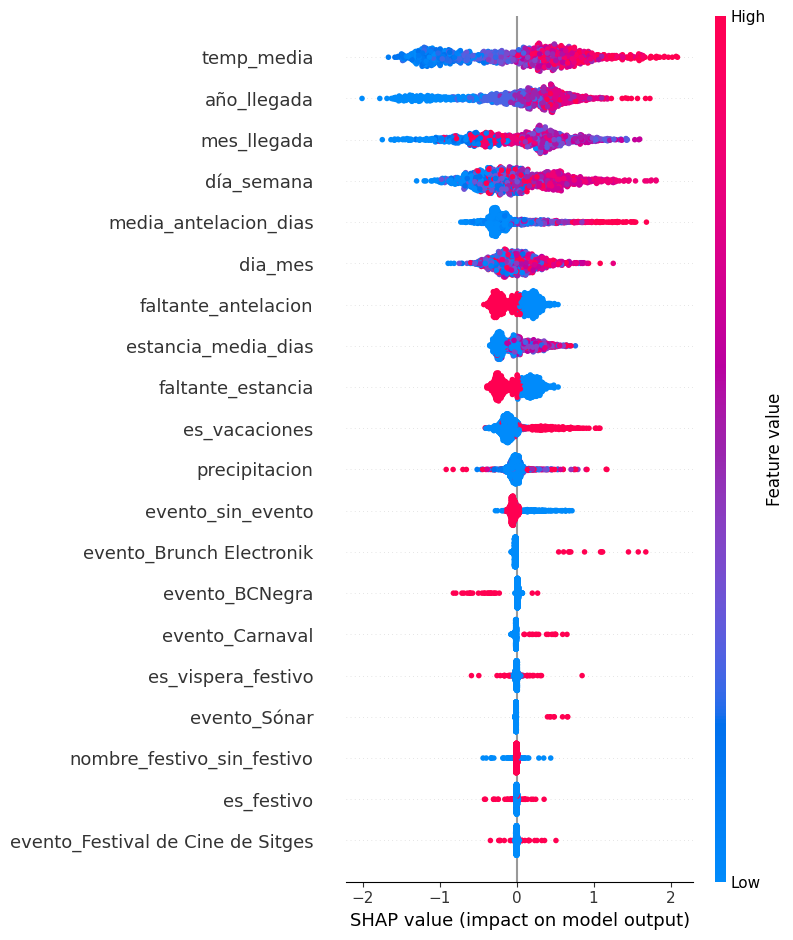

In [18]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
explainer = shap.TreeExplainer(mejor_modelo)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)


In [19]:
# Escoge un índice de ejemplo del set de entrenamiento
i = 100
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_train.iloc[i])



Ambos enfoques coinciden en destacar ciertas variables como determinantes clave —entre ellas, la temperatura media diaria, el año y mes de llegada, el día de la semana, o la antelación media de las reservas— aunque el orden de relevancia difiere ligeramente entre métodos. Esta diferencia se explica por la naturaleza de cada técnica: mientras que feature_importances_ refleja el impacto estructural de las variables en la construcción del modelo, SHAP proporciona una medida más precisa y local de cómo cada variable contribuye a cada predicción concreta.

El análisis SHAP ha evidenciado que variables como la temperatura media, la temporalidad (año y mes), y el patrón de comportamiento de los clientes (día de la semana, antelación media y estacionalidad) influyen de forma significativa y consistente sobre el número de habitaciones ocupadas.

Este estudio no solo aporta interpretabilidad al modelo, sino que también permite extraer insights valiosos para la toma de decisiones del negocio, ya que identifica los factores que más afectan a la ocupación. En consecuencia, este análisis refuerza la validez del modelo propuesto y su capacidad para capturar los patrones clave del comportamiento de los clientes.

In [20]:
import pandas as pd

df_resultados = pd.DataFrame({
    'prediccion_modelo': y_pred,
    'error_modelo': errores
}, index=y_test.index)


In [21]:
# Asegúrate de que df_final tiene como índice algo compatible (por ejemplo, fecha o el mismo índice que X_test/y_test)
df_final_con_resultados = df_copia.join(df_resultados, how='left')



In [22]:
df_copia.head()

,fecha,habitaciones_ocupadas,temp_media,precipitacion,día_semana,es_festivo,nombre_festivo,es_vispera_festivo,es_vacaciones,evento,media_antelacion_dias,num_cancelaciones,estancia_media_dias,año_llegada,mes_llegada
0,2021-04-01,1,14.94,0.0,3,False,NaN,True,False,NaN,14.0,0,3.0,2021,4
1,2021-04-02,6,16.20,0.0,4,True,Viernes Santo,False,False,NaN,14.0,0,2.2,2021,4
2,2021-04-03,7,16.40,0.4,5,False,NaN,False,False,NaN,43.0,0,2.0,2021,4
3,2021-04-04,3,14.47,0.0,6,False,NaN,True,False,NaN,16.0,0,2.0,2021,4
4,2021-04-05,1,14.75,0.0,0,True,Lunes de Pascua,False,False,NaN,NaN,0,NaN,2021,4


In [23]:
df_final_con_resultados.head()

,fecha,habitaciones_ocupadas,temp_media,precipitacion,día_semana,es_festivo,nombre_festivo,es_vispera_festivo,es_vacaciones,evento,media_antelacion_dias,num_cancelaciones,estancia_media_dias,año_llegada,mes_llegada,prediccion_modelo,error_modelo
0,2021-04-01,1,14.94,0.0,3,False,NaN,True,False,NaN,14.0,0,3.0,2021,4,NaN,NaN
1,2021-04-02,6,16.20,0.0,4,True,Viernes Santo,False,False,NaN,14.0,0,2.2,2021,4,NaN,NaN
2,2021-04-03,7,16.40,0.4,5,False,NaN,False,False,NaN,43.0,0,2.0,2021,4,NaN,NaN
3,2021-04-04,3,14.47,0.0,6,False,NaN,True,False,NaN,16.0,0,2.0,2021,4,NaN,NaN
4,2021-04-05,1,14.75,0.0,0,True,Lunes de Pascua,False,False,NaN,NaN,0,NaN,2021,4,NaN,NaN


In [24]:
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo
modelo_rf_completo = RandomForestRegressor(
    n_estimators=300,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=None,
    random_state=42
)

# Entrenar el modelo con TODOS los datos
modelo_rf_completo.fit(X, y)


RandomForestRegressor(max_features='sqrt', n_estimators=300, random_state=42)

In [25]:
y_pred_todo = modelo_rf_completo.predict(X)


In [26]:
df_final_con_resultados['prediccion_modelo_todo'] = y_pred_todo
df_final_con_resultados['error_modelo_todo'] = df_encoded['habitaciones_ocupadas'] - df_final_con_resultados['prediccion_modelo_todo']


In [27]:
df_final_con_resultados.head(50)

,fecha,habitaciones_ocupadas,temp_media,precipitacion,día_semana,es_festivo,nombre_festivo,es_vispera_festivo,es_vacaciones,evento,media_antelacion_dias,num_cancelaciones,estancia_media_dias,año_llegada,mes_llegada,prediccion_modelo,error_modelo,prediccion_modelo_todo,error_modelo_todo
0,2021-04-01,1,14.94,0.0,3,False,NaN,True,False,NaN,14.000000,0,3.000000,2021,4,NaN,NaN,1.903333,-0.903333
1,2021-04-02,6,16.20,0.0,4,True,Viernes Santo,False,False,NaN,14.000000,0,2.200000,2021,4,NaN,NaN,5.463333,0.536667
2,2021-04-03,7,16.40,0.4,5,False,NaN,False,False,NaN,43.000000,0,2.000000,2021,4,NaN,NaN,6.166667,0.833333
3,2021-04-04,3,14.47,0.0,6,False,NaN,True,False,NaN,16.000000,0,2.000000,2021,4,NaN,NaN,3.193333,-0.193333
4,2021-04-05,1,14.75,0.0,0,True,Lunes de Pascua,False,False,NaN,NaN,0,NaN,2021,4,NaN,NaN,1.533333,-0.533333
5,2021-04-06,0,13.52,0.2,1,False,NaN,False,False,NaN,NaN,0,NaN,2021,4,NaN,NaN,0.266667,-0.266667
6,2021-04-07,0,10.36,0.8,2,False,NaN,False,False,NaN,NaN,0,NaN,2021,4,NaN,NaN,0.430000,-0.430000
7,2021-04-08,1,12.41,0.0,3,False,NaN,False,False,NaN,3.000000,0,1.000000,2021,4,NaN,NaN,1.873333,-0.873333
8,2021-04-09,1,12.55,0.0,4,False,NaN,False,False,NaN,23.000000,0,2.000000,2021,4,NaN,NaN,2.093333,-1.093333
9,2021-04-10,2,12.76,2.2,5,False,NaN,False,False,NaN,0.000000,0,1.000000,2021,4,NaN,NaN,2.890000,-0.890000


In [28]:
# Guardar el dataframe con predicciones
df_final_con_resultados.to_csv('df_final_con_resultados.csv', index=False, decimal=",")


In [29]:
from google.colab import files
files.download('df_final_con_resultados.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Suponiendo que ya tienes y_pred y y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calcula error absoluto
errores = abs(y_test - y_pred)
error_medio = errores.mean()
error_std = errores.std()
dias_con_error_pequeño = (errores <= 1).sum()
porcentaje_error_bajo = dias_con_error_pequeño / len(errores) * 100

# Crear resumen
df_metricas = pd.DataFrame({
    'Métrica': ['RMSE', 'MAE', 'R²', 'STD del error'],
    'Valor': [rmse, mae, r2, error_std]
})

# Guardar para importar a Power BI
df_metricas.to_csv("metricas_modelo.csv", index=False, decimal=",")


In [31]:
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
print("Error medio diario:", error_medio)
print("STD del error:", error_std)
print("% días con error ≤ 1 hab.:", porcentaje_error_bajo)

RMSE: 2.6290098431263536
MAE: 2.076362612612613
R²: 0.4389245801771273
Error medio diario: 2.076362612612613
STD del error: 1.6153098801569505
% días con error ≤ 1 hab.: 32.432432432432435


In [32]:
df_errores.to_csv("errores_modelo.csv", index=False, decimal=",")


In [33]:
importancia_df.to_csv("importancia_variables.csv", index=False, decimal=",")

In [34]:
df_resultados_modelos.to_csv("resultados_modelo.csv", index=False, decimal=",")